In [1]:
%matplotlib widget
import ipywidgets as widgets
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import numpy as np

interactive(children=(IntSlider(value=5000, description='NEI', max=20000, step=100), IntSlider(value=400, desc…

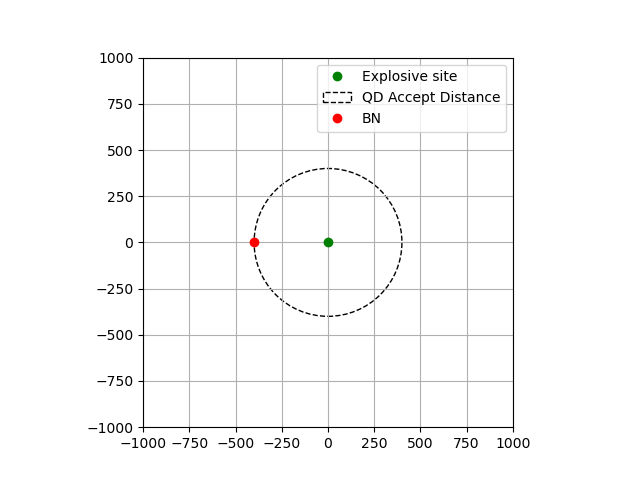

In [5]:
fig, ax = plt.subplots()
#small test
@widgets.interact(NEI=(0, 20000, 100),R=(0,1000,10),angle=(0, 360, 1),tilstede=(0,1,0.05))
def update(NEI=5000,R=400,angle=180,tilstede=1):
    plt.cla()
    ax.grid(True)
    ax.set_aspect(1)
    #plot dot in origin
    ax.plot(0, 0, 'go', label='Explosive site')
    # ax.set_ylim([-(R+5), R+5])
    # ax.set_xlim([-(R+5), R+5])
    ax.set_ylim([-1000, 1000])
    ax.set_xlim([-1000,1000])
    Z = R/NEI**(1/3)
    def Incident_pressure(Z):
        if Z <= 2.9:
            Az = 7.2106
            Bz = -2.1069
            Cz = -0.3229
            Dz = 0.1117
            Ez = 0.0685
        elif Z <= 23.8:
            Az = 7.5938
            Bz = -3.0523
            Cz = 0.40977
            Dz = 0.0261
            Ez = -0.01267
        elif Z > 23.8:
            Az = 6.0536
            Bz = -1.4066
            Cz = 0
            Dz = 0
            Ez = 0
    # multiply with 0.01 to convert from kPa to Bar
        return 0.01*np.exp(Az+Bz*np.log(Z)+Cz*(np.log(Z))**2+Dz*(np.log(Z))**3+Ez*(np.log(Z))**4)
    if Incident_pressure(Z) < 0.101:
        A_leth = 0.7441
        B_leth = -1.5790
    elif Incident_pressure(Z) >= 0.101:
        A_leth = 2.1622
        B_leth = 1.6721
    z_leth = A_leth * np.log(Incident_pressure(Z)) + B_leth
    def leth_2(z_leth):
        p_leth = 0.2316419
        t = 1/(1+p_leth*np.abs(z_leth))
        b1 = 0.31938153
        b2 = -0.356563782
        b3 = 1.781477937
        b4 = -1.821255978
        b5 = 1.330274429
        leth_2 = (1/(np.sqrt(2*np.pi)))*np.exp((-1/2)*(z_leth**2))*(b1*t+b2*t**2+b3*t**3+b4*t**4+b5*t**5)
        if z_leth < 0:
            leth_2 = 1-leth_2
        return leth_2
    leth_BN = leth_2(-z_leth)
    Q_amr = NEI/1000
    # mass of standard BNS 10 ft in tons
    m_building = 2490/1000
    m_earth = 100*Q_amr
    # assuming 10 % gross weight over actual
    m_ammo = 1.1*Q_amr - Q_amr
    m_tot = m_building + m_earth + m_ammo
    density = 0.36 * m_tot *Q_amr**(-0.58)*np.exp(-0.047*R*Q_amr**(-0.29))
    z_deb = -4.103 + 0.4631*np.log(density)+0.2524*np.sqrt((np.log(density)-3.285)**2+39.95)
    leth_deb = leth_2(-z_deb)
    leth_tot = 1-((1-leth_BN)*(1-leth_deb))
    # plot circle
    # accept_radii = Circle((0,0),R, fill=False, label='QRA Distance')
    # ax.add_artist(accept_radii)
    # plot QD circle
    QD_bolig = 22.2*NEI**(1/3)
    if QD_bolig < 400:
        QD_bolig = 400
    QD_radii = Circle((0,0),QD_bolig, fill=False, ls='--', label='QD Accept Distance')
    ax.add_patch(QD_radii)
    # find the end point
    endy = 0 + R * np.sin(np.radians(angle))
    endx = R * np.cos(np.radians(angle))

    # plot the points
    # ax.plot([0, endx], [0, endy])
    ax.plot(endx, endy, 'or', label='BN')
    ax.legend();
    Ri = (1.5*10**(-4)+ NEI*1*10**(-7)) * leth_tot * tilstede
    print("Individual risk is",Ri)
    print("Lethality is", leth_tot)
    if Ri <= 2*10**(-7):
        print("Akseptkriteriet er oppfylt")
    else:
        print("Kriteriet er ikke oppfylt")

Programmet sammenligner risikoakseptkriteriet for tredjeperson med sikkerhetsavstanden fra et eksplosivlager til bolighus jf. § 37 i eksplosivforskriften.
Trykket er beregnet på bagrunn av forenklede polynomer for Kingery og Bulmash sine eksplosivberegninger gitt av Swisdak, M. i 1994: 
    https://apps.dtic.mil/sti/pdfs/ADA526744.pdf

Dødeligheten tar utgangspunkt i AMRISK versjon 2.0 utgitt av FFI:
    https://publications.ffi.no/nb/item/asset/dspace:3237/06-01863.pdf

Kildekode tilgjengelig på github:
    https://github.com/Freeyolo/DSB/blob/main/Risk%20visualizer.ipynb
    
Dødelighet og individuell risiko gir samme verdi som AMRISK for følgende parametere:
    
    PES:
        FS (free standing)
        Mag mass = 2490 (standard 10 ft BNS container)
        
    Charge data:
        Gross wt = 1.1 * NEI (10 % økt total vekt)
        Event frequency, P = A + BxQ (container, A = 1,5E-04)
   
    Object data:
        BN (building normal)
        PF (point fixed)
        Number exposed = 1
        
